This will assume that you have downloaded some of the data from the dropbox, or have simulated your own data in the same format as we are generating with quadriga power matrix. I have written some helper functions which are copied here and are available on the github as well.

In [15]:
# Required libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import json

########## Optional libraries for full functionality ########
# if you want to get the BS locations before the simulation, you will need utm to convert from longitude and latitude to relative distances
# import utm

In [16]:
# Define the path to the folder within tracks that you want to use
# this can include subfolders as well, or be relative paths instead

multi_folder_dir = r'D:/UT/Facebook/quadriga/tracks/Dataset 1/'
# multi_folder_dir = r'/Users/rmd2758/Documents/UT/Facebook/quadriga/tracks/DT-1'


# Note that for the DT-1 folder, there are subfolders for each power
# for the other folders (i.e. DT3), they are only divided by the datetime
folder_dir = r'D:/UT/Facebook/quadriga/tracks/Dataset 1/DT6/07-31-12-54/'
# folder_dir = r'/Users/rmd2758/Documents/UT/Facebook/quadriga/tracks/DT-1/10W/07-01-16-37/'

### Helper functions

In [17]:
def sum_dBm(x, axes):
    """
    Assumes you have an ndarray that you wish to sum the power over some axes, but it is currently in dBm
    """
    x = 10**((x-30)/10.0)
    x = np.sum(x, axes)
    x = 10*np.log10(x)+30
    return x


def plot_power(power, x_coordinates, y_coordinates, tx_locs, plot_range=None):
    """
    Plots the powermap for a given tx_powers ndarray and its coordinates
    """
    power = np.squeeze(power)
    if len(power.shape) == 2:
        plt.title("Power map for One Sector and One Tx")
    # case where you only want to plot one transmitter or one sector
    elif len(power.shape) == 3:
        m = np.argmin(power.shape)
        power = sum_dBm(power, m)
        if m == 0:
            plt.title("Power map for One Sector")
        else:
            plt.title("Power map for One Tx")
    # plot over transmitters and sectors
    elif len(power.shape) == 4:
        power = sum_dBm(power, (0, -1))
        plt.title("Power map over all transmitters and sectors")

    plt.imshow(power, extent=[np.min(x_coordinates), np.max(x_coordinates), np.min(y_coordinates), np.max(y_coordinates)], origin='lower')
    
    if plot_range is not None:
        plt.clim(plot_range[0], plot_range[1])
    else:
        plt.clim(np.max(power) - 95, np.max(power) - 10)
    c = plt.colorbar()
    plt.grid()
    c.set_label("Received Power [dBm]")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.scatter(tx_locs[:, 0], tx_locs[:, 1], c='red', s=25, marker='x')
    plt.show()


def get_powermatrix(path):
    """
    Returns the important data from the file at the location given. This is only for the powermatrix information.
    Specifically it returns the x and y coordinates, the transmitter power, the tx locations, and the power at each location
    """
    if path[-1] != '/':
        path = path+'/'
    with open(path+'powermatrix.json') as f:
        data = json.load(f)

    # get the x and y coordinates
    x_coor = np.array(data['x'], dtype=np.float32)
    y_coor = np.array(data['y'], dtype=np.float32)
    P_Tx = np.array(data['ptx'], dtype=np.int64) # transmit power in watts
    try:
        N_tx = int(re.search(r'\d+', list(data.keys())[-1]).group())
    except ValueError:
        print("Unable to determine the number of transmitters, assuming only 1")
        N_tx = 1

    # gather the power into a single ndarray (transmitter, x, y, sector)
    rx_powers = np.zeros((N_tx, len(x_coor), len(y_coor), 3), dtype=np.float32)
    # transmitter locations (transmitter, [x, y, z])
    tx_locations = np.zeros((N_tx, 3))

    for i in range(1, N_tx+1):
        label = 'Tx{}'.format(i)
        rx_powers[i-1] = data[label+'pwr']
        tx_locations[i-1] = data[label+'loc']

    return x_coor, y_coor, P_Tx, rx_powers, tx_locations


def get_multi_powermap(path):
    """
    Obtain the powermap data from multiple powermaps that are all within a parent directory. This will
    search child folders and lower levels as well
    """
    # determine where powermaps are
    all_matrices = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".json"):
                all_matrices.append(root.replace("\\", "/"))
                
    # grab the first set of data
    if len(all_matrices) == 0:
        print("No powermaps found, interrupting")
        return 0
    else:
        x_co, y_co, Ptx, rx_pow, tx_loc = get_powermatrix(all_matrices[0])
        
    # for each one, gather the information and store into higher dimensional arrays
    # assumes tx_loc, x_co, y_co all stay the same
    print(all_matrices)
    all_P_Tx = np.zeros(([len(all_matrices)] + list(Ptx.shape)))
    all_rx_powers = np.zeros(([len(all_matrices)]+list(rx_pow.shape)))
    all_P_Tx[0] = Ptx
    all_rx_powers[0] = rx_pow
    # gather the rest of the data
    for i in range(len(all_matrices)):
        print(i)
        x_co, y_co, Ptx, rx_pow, tx_loc = get_powermatrix(all_matrices[i])
        all_P_Tx[i] = Ptx
        all_rx_powers[i] = rx_pow
        
    return x_co, y_co, all_P_Tx, all_rx_powers, tx_loc
    

def get_tracks(file_path):
    """
    Returns the information from the frequency response of the track data for each UE. Not complete yet
    """
    pass


def get_tx_loc_from_csv(filepath):
    """
    Gives the locations of the tranmistters from a csv file similar to the one given to use by Mavenir
    """
    import utm

    df = pd.read_csv(filepath)
    rows = len(df.index)
    lats = df['Lat']
    longs = df['Long']
    abs_pos = np.zeros((rows, 3))  # there are three sectors for each BS and one x, y, z coordinate so 1/3 of the rows are useless
    for i in range(rows):
        abs_pos[i, :2] = utm.from_latlon(lats[i], longs[i])[:2]
        abs_pos[i, 2] = int(re.search(r'\d+', df['Tower ht'][i]).group())

    # throw away repetitive values for every 3 rows
    abs_pos = abs_pos[0:-1:3, :]
    
    # choose a center point now by the one closest to the middle
    mid_point = np.mean(abs_pos[:, :2], axis=0)
    center_tx_id = np.argmin(np.linalg.norm(mid_point - abs_pos[:, :2], axis=1))
    center_tx_pos = abs_pos[center_tx_id]
    
    # get the relative locations for each transmitter from this point
    relative_pos = abs_pos - center_tx_pos
    relative_pos[:, 2] = abs_pos[:, 2]  # the heights should not be relative
    
    # round the positions because this may not be exact to less than 1m
    relative_pos = np.round(relative_pos)
    return relative_pos


def get_tx_sector_orientations(filepath):
    df = pd.read_csv(filepath)
    rows = len(df.index)
    azi = df['Azimuth']
    e_tilt = df['E-TILT']
    m_tilt = df['M-TILT']
    sector_info = np.zeros((rows, 2))
    sector_info[:, 0] = azi
    sector_info[:, 1] = e_tilt+m_tilt

    return sector_info

### Read a single power matrix and plot the results

In [18]:
x_cord, y_cord, P_tx, rx_pows, tx_locations = get_powermatrix(folder_dir)

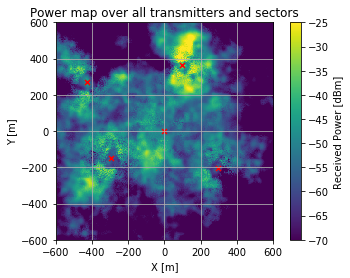

In [24]:
# Plot the data for all transmitters and all sectors
plot_power(rx_pows[:, :, :, :], x_cord, y_cord, tx_locations, plot_range=[-25, -70]) # rx_pows is shape [tx, x, y, sector]

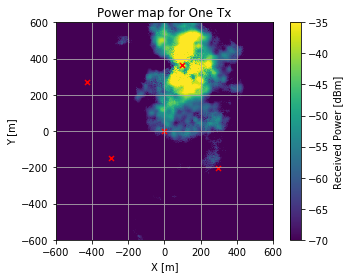

In [35]:
# Plot the data for only the first transmitter
plot_power(rx_pows[3, :, :, :], x_cord, y_cord, tx_locations, plot_range=[-35, -70])

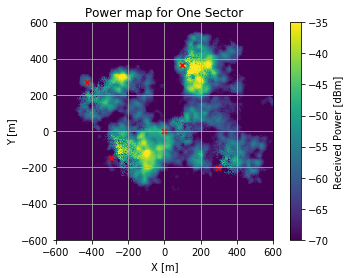

In [26]:
# Plot the data for only one sector 
plot_power(rx_pows[:, :, :, 0], x_cord, y_cord, tx_locations, plot_range=[-35, -70])

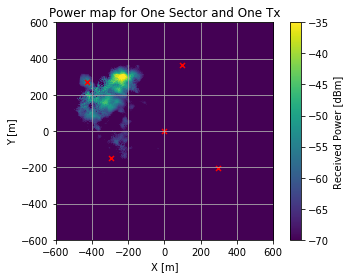

In [27]:
# Plot the data for only one sector of one transmitter
plot_power(rx_pows[0, :, :, 0], x_cord, y_cord, tx_locations, plot_range=[-35, -70])

### Handling multiple powermaps

In [4]:
x_cord, y_cord, P_tx, rx_pows, tx_locations = get_multi_powermap(multi_folder_dir)

['D:/UT/Facebook/quadriga/tracks/DT10/07-31-11-10', 'D:/UT/Facebook/quadriga/tracks/DT5/07-31-13-44', 'D:/UT/Facebook/quadriga/tracks/DT6/07-31-12-54', 'D:/UT/Facebook/quadriga/tracks/DT7/07-31-10-38', 'D:/UT/Facebook/quadriga/tracks/DT8/07-31-11-50', 'D:/UT/Facebook/quadriga/tracks/DT9/07-31-12-17']
0
1
2
3
4
5


In [5]:
print(rx_pows.shape) # this is [no_powermaps, no_tx, x, y, no_sectors]
print(P_tx)

(6, 5, 241, 241, 3)
[40. 40. 40. 40. 40. 40.]


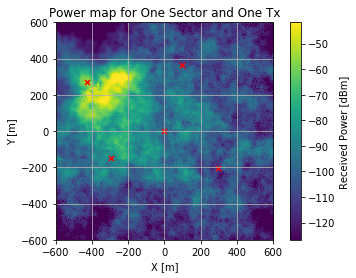

In [22]:
plot_power(rx_pows[0, 0, :, :, 0], x_cord, y_cord, tx_locations)

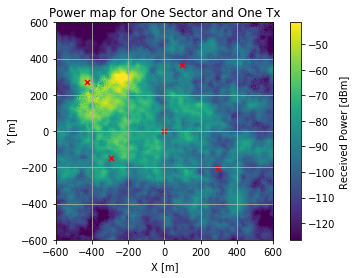

In [23]:
plot_power(rx_pows[1, 0, :, :, 0], x_cord, y_cord, tx_locations)

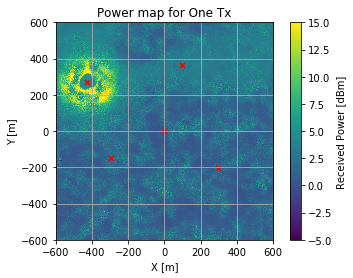

In [24]:
plot_power(rx_pows[0, 0, :, :, :] - rx_pows[1, 0, :, :, :], x_cord, y_cord, tx_locations, plot_range=[15, -5])

In [ ]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10, 8]

Downtilt = 1


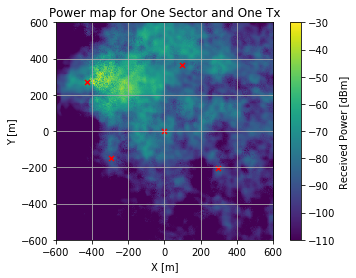

Downtilt = 2


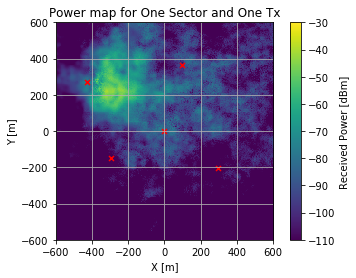

Downtilt = 3


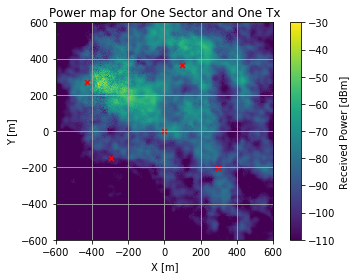

Downtilt = 4


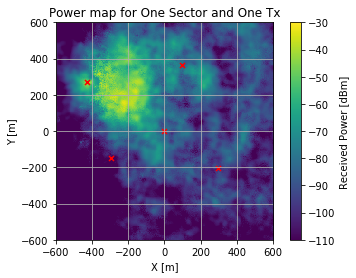

Downtilt = 6


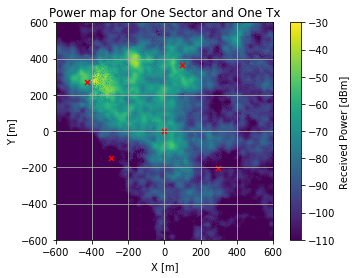

Downtilt = 7


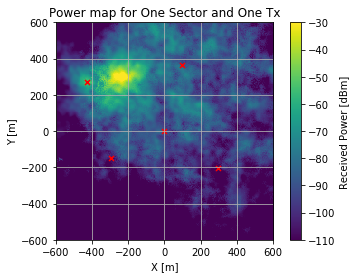

Downtilt = 8


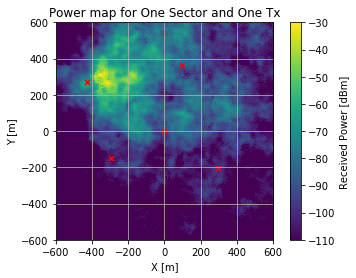

Downtilt = 9


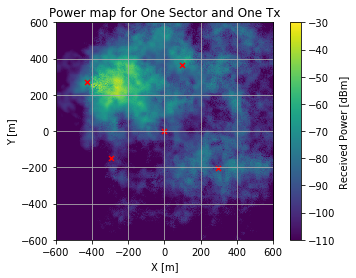

In [47]:
downtilts = [1, 2, 3, 4, 6, 7, 8, 9]

for i in range(len(rx_pows)-1):
    print(f"Downtilt = {downtilts[i]}")
    plot_power(rx_pows[i, 0, :, :, 0], x_cord, y_cord, tx_locations, plot_range=[-30, -110])